```
Copyright 2019, 2020. IBM All Rights Reserved.
```

```
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# Allstate Claim Prediction Challenge using Snap ML
<div class="alert alert-block alert-info">
    <b>Snap ML</b> is packaged with <b>IBM® Watson™ Machine Learning Community Edition (WML CE)</b> in a conda package <b>pai4sk</b>.
</div>

### Allstate Claim Prediction
This example is based on a competition in Kaggle - https://www.kaggle.com/c/ClaimPredictionChallenge
In this notebook we will train a <b>Logistic Regression</b> model to predict if a customer would claim a bodily injury liability insurance based on the characteristics of the insured customer's vehicle.<br/>
We will train the models using <b>scikit-learn</b> and <b>SnapML</b>, and compare the results.

### Data source
Dataset used for this notebook is downloaded from https://www.kaggle.com/c/ClaimPredictionChallenge/data with all rights reserved by Kaggle and Allstate Corporation. Here we have used Kaggle API (https://github.com/Kaggle/kaggle-api) to download the dataset.

### Conda packages used for this notebook 
- `pai4sk       1.6.0   (Package for IBM Snap ML, provided in WML CE 1.7.0)`
- `scikit-learn 0.22.1  (Package for sklearn)`
- `pandas       1.0.0   (Package for pandas)`
- `kaggle       1.5.6   (Package for using Kaggle APIs)`
- `matplotlib   3.1.3   (Package for matplotlib)`

### System Configuration 

|Configuration Parameter |	Value                         |
|:-----------------------|:-------------------------------|       
| **Machine** 	         | IBM Power9 AC922               |
| **CPU cores:**         | 44 (22 cores per socket)       |
| **Thread(s) per core:**| 4                              |
| **GPU** 	             | NVIDIA Tesla V100 SXM2 16GB    |


In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, normalize
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

## A. Download the dataset using kaggle APIs

In [2]:
!kaggle competitions download ClaimPredictionChallenge
!unzip ClaimPredictionChallenge.zip
!unzip train_set.zip

## B. Load the data into pandas dataframe and view descriptive statistics

In [3]:
df = pd.read_csv('./train_set.csv')

In [4]:
df.head().T

,0,1,2,3,4
Row_ID,1,2,3,4,5
Household_ID,1,2,3,3,3
Vehicle,3,2,1,1,2
Calendar_Year,2005,2005,2005,2006,2005
Model_Year,2005,2003,1998,1998,2001
Blind_Make,K,Q,AR,AR,D
Blind_Model,K.78,Q.22,AR.41,AR.41,D.20
Blind_Submodel,K.78.2,Q.22.3,AR.41.1,AR.41.1,D.20.0
Cat1,D,B,B,B,J
Cat2,C,C,?,?,C


In [5]:
print("This dataset has " + str(df.shape[0]) + " observations and " + str(df.shape[1]) + " features")

This dataset has 13184290 observations and 35 features


In [6]:
df.describe()

,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
count,1.318429e+07,1.318429e+07,1.318429e+07,1.318429e+07,1.318429e+07,1.318429e+07,1.318429e+07,1.318429e+07,1.318429e+07,1.318429e+07,1.318429e+07,1.318429e+07,1.318429e+07,1.318429e+07,1.318429e+07,1.318429e+07,1.318429e+07,1.318429e+07
mean,6.592146e+06,4.128242e+06,1.894002e+00,2.006052e+03,1.999312e+03,-1.011925e-02,-6.508702e-02,-2.543391e-02,-5.456792e-02,3.838594e-03,-4.012271e-02,-2.421288e-02,-5.856059e-02,1.468410e-02,1.751169e-02,1.354226e-02,1.851376e-02,1.360658e+00
std,3.805977e+06,2.248415e+06,1.173861e+00,8.123720e-01,5.211866e+00,9.800609e-01,9.684165e-01,1.018902e+00,9.680170e-01,9.910490e-01,9.792078e-01,1.006433e+00,1.003954e+00,1.031040e+00,1.038212e+00,1.027748e+00,1.034274e+00,3.900103e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,2.005000e+03,1.981000e+03,-2.578222e+00,-2.493393e+00,-2.790335e+00,-2.508216e+00,-3.350344e+00,-2.376657e+00,-2.778490e+00,-2.163042e+00,-2.315299e-01,-2.661168e-01,-2.723372e-01,-2.514189e-01,0.000000e+00
25%,3.296073e+06,2.184932e+06,1.000000e+00,2.005000e+03,1.996000e+03,-6.658971e-01,-8.161519e-01,-8.696874e-01,-7.830189e-01,-6.860239e-01,-6.887650e-01,-8.984857e-01,-6.517680e-01,-2.315299e-01,-2.661168e-01,-2.723372e-01,-2.514189e-01,0.000000e+00
50%,6.592146e+06,4.257083e+06,2.000000e+00,2.006000e+03,2.000000e+03,-3.123581e-01,-1.245062e-01,-2.217581e-01,-1.064709e-01,-1.150981e-01,-2.372568e-01,-4.684193e-01,-2.568567e-01,-2.315299e-01,-2.661168e-01,-2.723372e-01,-2.514189e-01,0.000000e+00
75%,9.888218e+06,6.281433e+06,2.000000e+00,2.007000e+03,2.003000e+03,4.429298e-01,4.806838e-01,7.269956e-01,4.855086e-01,5.331405e-01,4.973212e-01,8.217801e-01,3.409799e-01,-2.315299e-01,-2.661168e-01,-2.723372e-01,-2.514189e-01,0.000000e+00
max,1.318429e+07,7.542113e+06,2.900000e+01,2.007000e+03,2.009000e+03,5.143392e+00,7.829420e+00,5.563325e+00,7.589263e+00,4.018167e+00,4.584289e+00,4.127148e+00,4.735074e+01,6.627110e+00,8.883081e+00,8.691144e+00,6.388802e+00,1.144075e+04


## C. Visualize claims distribution

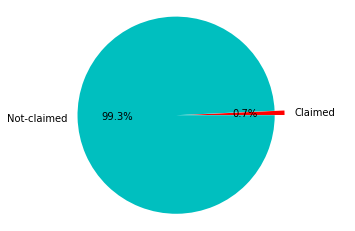

In [7]:
import matplotlib.pyplot as plt

labels = 'Claimed', 'Not-claimed'
sizes = [len(df[df.Claim_Amount>0]), len(df[df.Claim_Amount==0])]
explode = (0.1, 0)
colors = ['r','c']

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', colors=colors)
ax.axis('equal')

plt.show()

<div class="alert alert-block alert-warning">
    The percentage of customers that claimed insurance is only <b>0.7</b> of the total insured vehicles. We will use the <b>class_weight</b> parameter of the frameworks for training to create a balanced model.
</div>

## D. Clean the dataset

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Drop columns we don't want to use for training

In [8]:
# Drop Row_ID column
df.drop(['Row_ID'],axis=1,inplace=True)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Replace all missing values with -1

In [9]:
# Missing values are coded as '?'
df.replace('?', np.NaN, inplace=True)

In [10]:
# Replace the missing values with -1
df.fillna(-1, inplace=True)

## E. Split data into train and test sets

In [11]:
# Retrieve the target variable 'Claim Amount', and drop that from the train
df_Y = df[['Claim_Amount']]
df_X = df.drop(['Claim_Amount'],axis=1)

In [12]:
# Split out 30% of the observations for test 
X_train, X_test, y_train, y_test  = train_test_split (df_X, df_Y, test_size=0.3, random_state=42)
print('X_train.shape = ', X_train.shape)
print('X_test.shape = ',  X_test.shape)

X_train.shape =  (9229003, 33)
X_test.shape =  (3955287, 33)


In [13]:
# Reset index after split for concat operations
X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)

## F. Preprocess data

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Label encoding for some features

In [14]:
for col in ['Blind_Make', 'Blind_Model', 'Blind_Submodel', 'NVCat']:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

    le = LabelEncoder()

    # fit label encoder
    le.fit(X_train[col])

    # extract dictionary mapping from label encoder
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))

    # replace categories with labels (assign label -1 if not in dict)
    X_train[col] = X_train[col].map(lambda x: le_dict.get(x, -1))
    X_test[col] = X_test[col].map(lambda x: le_dict.get(x, -1))

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; One-hot encoding for the categorical features

In [15]:
categoricalColumns = ['Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8', 'Cat9', 'Cat10', 'Cat11', 'Cat12']
for col in categoricalColumns:

    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

    oh = OneHotEncoder(handle_unknown='ignore')
    tmp_train = oh.fit_transform(X_train[col].values.reshape(-1,1)).toarray()
    tmp_test = oh.transform(X_test[col].values.reshape(-1,1)).toarray()

    assert(tmp_train.shape[1] == tmp_test.shape[1])

    X_train = X_train.drop(col,axis=1)
    X_test = X_test.drop(col,axis=1)

    new_cols = [col + '-' + str(int(i)) for i in range(tmp_train.shape[1])]

    tmp_train = pd.DataFrame(tmp_train, columns=new_cols)
    tmp_test  = pd.DataFrame(tmp_test,  columns=new_cols)

    X_train = pd.concat([X_train, tmp_train],axis=1)
    X_test  = pd.concat([X_test,  tmp_test],axis=1)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Derive Vehicle Age and use it for training

In [16]:
for col in ['Calendar_Year']:
    X_train['Vehicle_Age'] = X_train['Calendar_Year'] - X_train['Model_Year']
    X_test['Vehicle_Age'] = X_test['Calendar_Year'] - X_test['Model_Year']

X_train.drop(['Calendar_Year'], axis=1, inplace=True)
X_test.drop(['Calendar_Year'], axis=1, inplace=True)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Features scaling and normalization

In [17]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)
X_train = min_max_scaler.transform(X_train)
X_test = min_max_scaler.transform(X_test)

In [18]:
# normalize and cast array to float32
X_train = normalize(X_train, axis=1, norm='l1').astype('float32')
X_test = normalize(X_test, axis=1, norm='l1').astype('float32')

## G. Convert labels for Binary Classification

In [19]:
# Convert y_train and y_test also to numpy arrays of float32
y_train = y_train.values.astype(np.float32).ravel()
y_test = y_test.values.astype(np.float32).ravel()

# Create a binary classification problem (will there be an insurance claim or not)
y_train = (y_train > 0).astype(int)
y_test = (y_test > 0).astype(int)

## H. Use Optimized data formats for each framework

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Compute the sparsity of the dataset

In [20]:
from numpy import count_nonzero
sparsity = 1.0 - (count_nonzero(X_train) / float(X_train.shape[0]*X_train.shape[1]) )
print("The train dataset is %f percent sparse " % (sparsity*100))

The train dataset is 65.718776 percent sparse 


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Since this dataset is reasonably sparse, convert it to scipy sparse csr_matrix
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Snap ML employs optimizations for the algorithms when applied to sparse data structures

In [21]:
# Both sklearn and snap ML provide support for sparse datasets for linear models
from scipy import sparse
X_train_sparse = sparse.csr_matrix(X_train)
X_test_sparse = sparse.csr_matrix(X_test)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Regularizer value used across frameworks

In [22]:
reg = 1.0

## I. Train using scikit-learn

### &nbsp;&nbsp;Logistic Regression

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Train

In [23]:
from sklearn.linear_model import LogisticRegression
skl_lor = LogisticRegression(C = 1.0/reg, class_weight='balanced')

t0 = time.time()
skl_lor.fit(X_train_sparse, y_train)
skl_train_time_lor = time.time()-t0
print("[sklearn-logreg] Training time (s): {0:.3f}".format(skl_train_time_lor))

[sklearn-logreg] Training time (s): 222.380


#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Evaluate gini score on test set

In [24]:
skl_pred = skl_lor.predict(X_test_sparse)
skl_gini  = 2.0*roc_auc_score(y_test, skl_pred)-1.0
print('[sklearn-logreg] gini_score %.4f' % (skl_gini))

[sklearn-logreg] gini_score 0.1250


## J. Train using SnapML

### &nbsp;&nbsp;Logistic Regression

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Train using "<font color='red'>CPU</font>"

In [25]:
from pai4sk import LogisticRegression
sml_cpu_lor = LogisticRegression(regularizer=reg, class_weight='balanced', num_threads=16)

t0 = time.time()
sml_cpu_lor.fit(X_train_sparse, y_train)
sml_cpu_train_time_lor = time.time()-t0
print("[snapML-logreg] Training time (s): {0:.3f}".format(sml_cpu_train_time_lor))

[Info] Training will run in multi-threaded mode on CPU.
[snapML-logreg] Training time (s): 8.730


#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Evaluate gini score on test set

In [26]:
sml_cpu_pred = sml_cpu_lor.predict(X_test_sparse)
sml_cpu_gini  = 2.0*roc_auc_score(y_test, sml_cpu_pred)-1.0
print('[snapML-logreg] gini_score %.4f' % (sml_cpu_gini))

[snapML-logreg] gini_score 0.1248


#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Train using "<font color='red'>GPU</font>"

In [27]:
from pai4sk import LogisticRegression
sml_gpu_lor = LogisticRegression(regularizer=reg, class_weight='balanced', use_gpu=True)

t0 = time.time()
sml_gpu_lor.fit(X_train_sparse, y_train)
sml_gpu_train_time_lor = time.time()-t0
print("[snapML-logreg] Training time (s): {0:.3f}".format(sml_gpu_train_time_lor))

[Info] If set num_threads should be a multiple of 32. GPU training will run with num_threads=256.
[Warning] Parameter device_ids not set. The training will run on GPU 0.
[snapML-logreg] Training time (s): 3.235


#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Evaluate gini score on test set

In [28]:
sml_gpu_pred = sml_gpu_lor.predict(X_test_sparse)
sml_gpu_gini  = 2.0*roc_auc_score(y_test, sml_gpu_pred)-1.0
print('[snapML-logreg] gini_score %.4f' % (sml_gpu_gini))

[snapML-logreg] gini_score 0.1259


## K. Speedup summary
<div class="alert alert-block alert-info">
The following results were obtained on an IBM Power AC922 server with NVIDIA Tesla V100 SXM2 16GB GPUs as mentioned in <a href='#System-Configuration'>System Configuration</a>.
<br/>Speedup times may vary based on the system architecture, load and software package versions used.
</div>

In [29]:
print("SnapML(CPU) vs Sklearn training time speedup (Logistic) : %d X " % (skl_train_time_lor/sml_cpu_train_time_lor))
print("SnapML(GPU) vs Sklearn training time speedup (Logistic) : %d X " % (skl_train_time_lor/sml_gpu_train_time_lor))

SnapML(CPU) vs Sklearn training time speedup (Logistic) : 25 X 
SnapML(GPU) vs Sklearn training time speedup (Logistic) : 68 X 
